C:\Users\cex\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/04/28 00:00:06 INFO mlflow.tracking.fluent: Experiment with name 'diabetes-risk-assessment' does not exist. Creating a new experiment.
2025/04/28 00:00:27 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


→ Selected RandomForest  |  ROC-AUC=0.8124,  Acc=0.7403
→ MLflow run ID: fd1c701b047e45b0a860300d32851b12
Generating SHAP summary plot…
SHAP summary saved to shap_summary.png


<Figure size 1000x600 with 0 Axes>

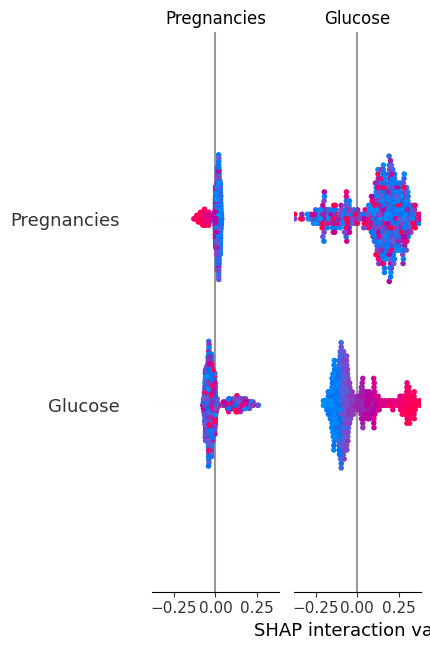

In [7]:
import joblib
import numpy as np
import pandas as pd
import dask.dataframe as dd
import mlflow
import mlflow.sklearn
import shap
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing  import StandardScaler
from sklearn.linear_model   import LogisticRegression
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import (
    roc_auc_score,
    classification_report,
    confusion_matrix,
    accuracy_score
)

# 1) Parallel load & clean with Dask
ddf = dd.read_csv(r"C:\Users\cex\Desktop\Predictive Analytics in Healthcare\diabetes.csv")
for col in ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]:
    # replace zeros with NaN, then fill with median per partition
    ddf[col] = ddf[col].map_partitions(
        lambda part: part.replace(0, np.nan).fillna(part.median())
    )
# bring into a pandas DataFrame
df = ddf.compute()

# 2) Features & train/test split
X = df.drop("Outcome", axis=1)
y = df["Outcome"]
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

# 3) Scale features
scaler = StandardScaler().fit(X_tr)
X_tr_s = scaler.transform(X_tr)
X_te_s = scaler.transform(X_te)

# 4) Define models & hyperparameter grids
models = {
    "LogisticRegression": (
        LogisticRegression(max_iter=200), 
        {"C": [0.01, 0.1, 1, 10]}
    ),
    "RandomForest": (
        RandomForestClassifier(random_state=42),
        {"n_estimators": [50, 100], "max_depth": [None, 5, 10]}
    )
}

best_estimators = {}
best_cv_params = {}
for name, (estimator, params) in models.items():
    grid = GridSearchCV(
        estimator, params, cv=5, scoring="roc_auc", n_jobs=-1
    )
    grid.fit(X_tr_s, y_tr)
    best_estimators[name] = grid.best_estimator_
    best_cv_params[name]   = grid.best_params_

# 5) Evaluate on test set, pick best by ROC-AUC
test_metrics = {}
for name, model in best_estimators.items():
    y_prob = model.predict_proba(X_te_s)[:,1]
    y_pred = model.predict(X_te_s)
    test_metrics[name] = {
        "roc_auc": roc_auc_score(y_te, y_prob),
        "accuracy": accuracy_score(y_te, y_pred),
        "report": classification_report(y_te, y_pred, output_dict=True),
        "confusion_matrix": confusion_matrix(y_te, y_pred)
    }

best_name = max(test_metrics, key=lambda n: test_metrics[n]["roc_auc"])
best_model = best_estimators[best_name]
metrics    = test_metrics[best_name]

# 6) MLflow logging
mlflow.set_experiment("diabetes-risk-assessment")
with mlflow.start_run():
    # params
    mlflow.log_param("chosen_model", best_name)
    mlflow.log_param("scaler", "StandardScaler")
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_params(best_cv_params[best_name])
    # metrics
    mlflow.log_metric("test_roc_auc",  metrics["roc_auc"])
    mlflow.log_metric("test_accuracy", metrics["accuracy"])
    # save model
    mlflow.sklearn.log_model(best_model, "model")
    run_id = mlflow.active_run().info.run_id

print(f"→ Selected {best_name}  |  ROC-AUC={metrics['roc_auc']:.4f},  Acc={metrics['accuracy']:.4f}")
print(f"→ MLflow run ID: {run_id}")

# 7) Save pipeline locally
pipeline = {"model": best_model, "scaler": scaler}
joblib.dump(pipeline, "diabetes_pipeline.joblib")

# 8) SHAP explainability
print("Generating SHAP summary plot…")
explainer = shap.TreeExplainer(best_model)  # works for RandomForest
shap_values = explainer.shap_values(X_tr_s)

# Plot and save
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_tr, feature_names=X.columns, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png")
print("SHAP summary saved to shap_summary.png")